In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

['LANL-Earthquake-Prediction.zip', 'sample_submission.csv', 'test', 'train_df.pkl', 'train.csv']


In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error

In [3]:
nrows = int(1e7)
#nrows = None

In [4]:
train = pd.read_csv('../input/train.csv', nrows=nrows, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [5]:
pd.options.display.precision = 15
train.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


In [6]:
#train.time_to_failure = train.time_to_failure * 1e6
#train.head()

In [7]:
#np.asarray(train.loc[:20, 'time_to_failure'].values, dtype=np.float32)

In [8]:
train.describe()

,acoustic_data,time_to_failure
count,1.000000000000000e+07,1.000000000000000e+07
mean,4.502072300000000e+00,5.183597857290694e+00
std,1.780707246615106e+01,5.091285869422851e+00
min,-4.621000000000000e+03,7.954798229500001e-04
25%,2.000000000000000e+00,6.498970646450000e-01
50%,4.000000000000000e+00,1.298898648350000e+00
75%,7.000000000000000e+00,1.089169840325000e+01
max,3.252000000000000e+03,1.154079998700000e+01


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 95.4 MB


In [10]:
train.loc[:10, 'time_to_failure']

0     1.4690999832
1     1.4690999821
2     1.4690999810
3     1.4690999799
4     1.4690999788
5     1.4690999777
6     1.4690999766
7     1.4690999755
8     1.4690999744
9     1.4690999733
10    1.4690999722
Name: time_to_failure, dtype: float64

In [11]:
#scaler = StandardScaler()
#scaler.fit(train)


In [12]:
#tof = scaler.transform(train)

In [13]:
#tof

In [14]:
#tof[:20, 1] * 1e7

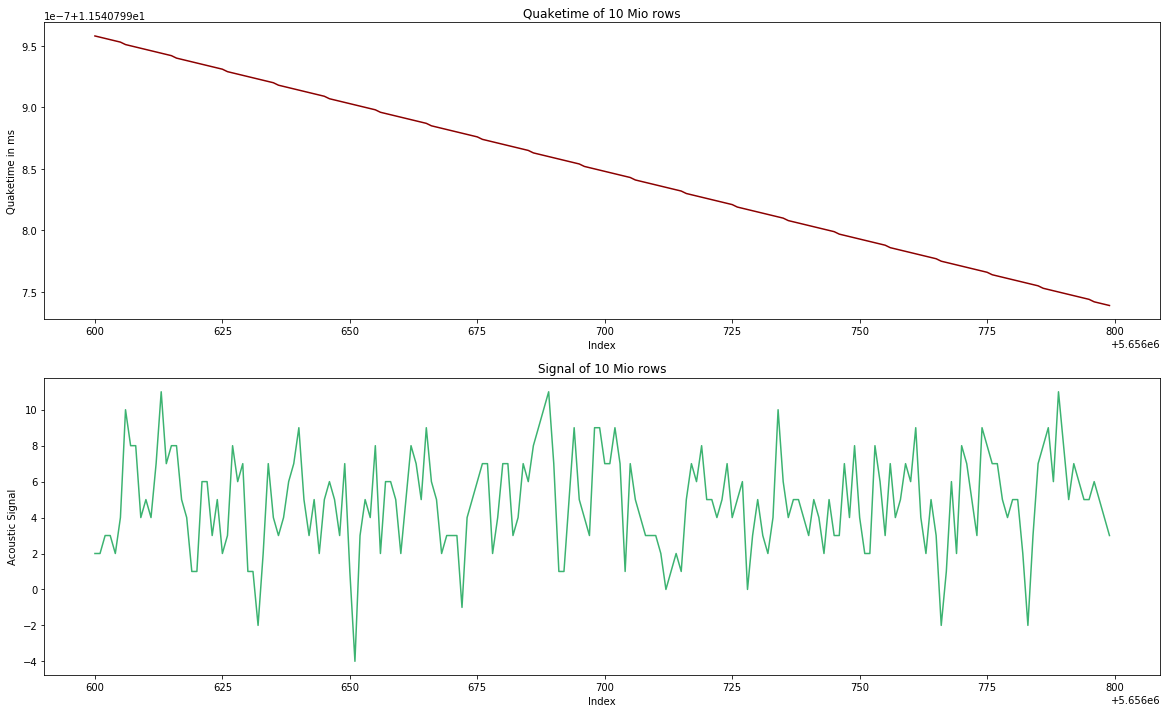

In [17]:
start = int(5.6566e6)
end = int(5.6568e6)
fig, ax = plt.subplots(2,1, figsize=(20,12))
ax[0].plot(train.index.values[start:end], train.time_to_failure.values[start:end], c="darkred")
ax[0].set_title("Quaketime of 10 Mio rows")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Quaketime in ms");
ax[1].plot(train.index.values[start:end], train.acoustic_data.values[start:end], c="mediumseagreen")
ax[1].set_title("Signal of 10 Mio rows")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Acoustic Signal");

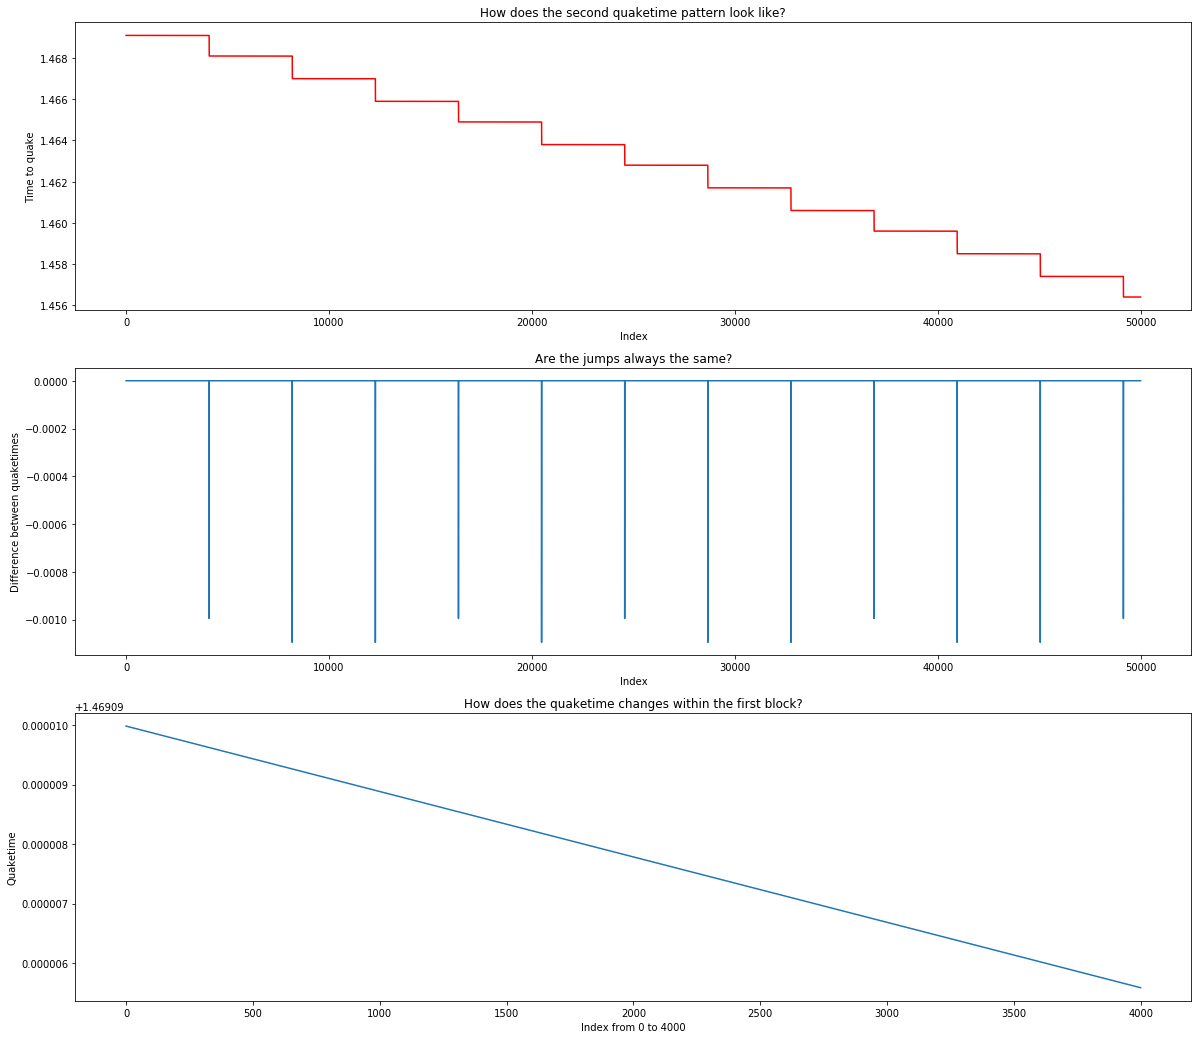

In [20]:
fig, ax = plt.subplots(3,1,figsize=(20,18))
ax[0].plot(train.index.values[0:50000], train.time_to_failure.values[0:50000], c="Red")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Time to quake")
ax[0].set_title("How does the second quaketime pattern look like?")
ax[1].plot(train.index.values[0:49999], np.diff(train.time_to_failure.values[0:50000]))
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Difference between quaketimes")
ax[1].set_title("Are the jumps always the same?")
ax[2].plot(train.index.values[0:4000], train.time_to_failure.values[0:4000])
ax[2].set_xlabel("Index from 0 to 4000")
ax[2].set_ylabel("Quaketime")
ax[2].set_title("How does the quaketime changes within the first block?");

In [ ]:
def find_period(df):
    diff = np.diff(df.time_to_failure.values)
    period_ends = np.nonzero(np.abs(diff) > 1)

In [6]:
diff = np.diff(train.time_to_failure.values)


In [15]:
period_ends = np.nonzero(np.abs(diff) > 1)

In [17]:
sorted(train.time_to_failure.values[period_ends])

[9.550396316600001e-05,
 9.5505761692e-05,
 0.00019549742592,
 0.00019550171692,
 0.0004954925329900001,
 0.00049549938876,
 0.0005954894541,
 0.00059551051299,
 0.0005955124393,
 0.0006954821747100001,
 0.00069549581485,
 0.0007954798229500001,
 0.00079548506392,
 0.0008955075072699999,
 0.0010954868680999998,
 0.0010954910954]

In [33]:
period_starts = [0] + list(period_ends[0] + 1)[:-1]

In [35]:
period_starts, period_ends

([0,
  5656574,
  50085878,
  104677356,
  138772453,
  187641820,
  218652630,
  245829585,
  307838917,
  338276287,
  375377848,
  419368880,
  461811623,
  495800225,
  528777115,
  585568144],
 (array([  5656573,  50085877, 104677355, 138772452, 187641819, 218652629,
         245829584, 307838916, 338276286, 375377847, 419368879, 461811622,
         495800224, 528777114, 585568143, 621985672]),))

In [36]:
len(train)

629145480

In [34]:
train.time_to_failure.values[period_starts]

array([ 1.46909998, 11.54079999, 14.18059999,  8.85669999, 12.69399999,
        8.0555    ,  7.059     , 16.1074    ,  7.9056    ,  9.6371    ,
       11.42640001, 11.02420001,  8.82810001,  8.56600001, 14.75180002,
        9.45950002])

In [43]:
train.time_to_failure.values

array([ 1.46909998,  1.46909998,  1.46909998, ..., 10.41289816,
       10.41289816, 10.41289816])

In [39]:
import pickle
with open('../input/train_df.pkl', 'wb') as f:
    pickle.dump(train, f, protocol=4)